In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image

# ---- ConvMixer Definition ----
class ConvMixer(nn.Module):
    def __init__(self, dim, depth, kernel_size=9, patch_size=7, n_classes=10):
        super().__init__()
        self.patch_embed = nn.Sequential(
            nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
            nn.GELU(),
            nn.BatchNorm2d(dim)
        )
        self.blocks = nn.Sequential(*[
            nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=kernel_size, padding="same", groups=dim),
                nn.GELU(),
                nn.BatchNorm2d(dim),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
            ) for _ in range(depth)
        ])
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(dim, n_classes)
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.blocks(x)
        return self.head(x)

In [2]:
from torch.utils.data import DataLoader
from hcmus.core import appconfig
from hcmus.utils import viz_utils
from hcmus.lbs import LabelStudioConnector
from hcmus.data import CroppedObjectClassificationDataset

2025-06-20 21:50:11.974 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
accepted_labels = """
8934804026817-nuoc-tuong-maggi-dau-nanh-thanh-diu-chai-700ml
8934804020402-nuoc-tuong-maggi-dau-nanh-dam-dac-700ml
8936048470524-mi-tom-3-mien-gold-vi-bo-ham-rau-thom-75g
8934822201272-bia-heineken-silver-lon-250ml
5054563022592-kem-danh-rang-sensodyne-giam-e-buotlam-sang-rang-100g
8934868166344-nuoc-rua-tay-lifebouy-450ml
8934707029182-hat-nem-knorr-thit-than-xuong-ong-va-tuy-900g
8934822361211-bia-heineken-khong-con-lon-330ml
8850006932346-kem-danh-rang-colgate-maxfresh-huong-tra-xanh-225g-+-ban-chai-long-to
8850006932322-kem-danh-rang-colgate-maxfresh-huong-bac-ha-225g-+-ban-chai-long-to
6920354827792-kem-danh-rang-colgate-maxfresh-tinh-chat-than-tre-225g-+-ban-chai-long-to
8936136163314-nuoc-mam-nam-ngu-3-trong-1-750ml
8934563198152-mi-hao-hao-chay-vi-rau-nam-74gr
8935049501503-nuoc-ngot-coca-cola-vi-nguyen-ban-lon-320ml
8936048470036-mi-3-mien-mi-chay-la-da-65g-(goi)
8935001215028-tra-tea-break-milk-350ml
8935006532755-kem-rua-mat-acnes-vitamin-lam-sang-da,-mo-seo-tham-50g
8935018801641-khan-bep-da-nang-pulppy-classic-2-lop-loc-2-cuon
8935024123287-ca-phe-sua-hoa-tan-g7-3in1-hop-336g-(16g-x-21-goi)
8935006538634-dau-tay-trang-hada-labo-sach-sau-duong-am-toi-uu-200ml
8934840000093-nuoc-khoang-chanh-lemona-chai-500ml
8997035601321-nuoc-uong-bu-dien-giai-bo-sung-ion-pocari-sweat-chai-900ml
4897036693162-nuoc-tang-luc-monster-mango-loco-355ml
809939073648-soda-sua-huong-vi-chuoi-milkis-banana
8934804038131-tra-hoa-qua-nestea-hoa-tan-hop-144g-12-goi-x-12g
8936048471248-mi-tom-chua-cay-dac-biet-3-mien-gold-goi-75g
8934804027333-tra-chanh-nestea-hoa-tan-hop-195g-15-goi-x-13g
8936010530881-tra-chanh-cozy-hoa-tan-hop-240g-16-goi-x-15g
8935049510604-nuoc-ngot-sprite-chai-320ml
8934588672118-nuoc-ngot-pepsi-khong-calo-vi-chanh-320ml
8935049501572-nuoc-ngot-fanta-vi-cam-lon-320ml
8935049500445-nuoc-ngot-fanta-chai-1.5l
8936721790017-nuoc-loc-th-true-water-chai-500ml
8935049501718-nuoc-ngot-sprite-lon-320ml
8936193070013-tra-xanh-khong-do-500ml
8935137601122-tra-xanh-thai-nguyen-100g
8934564600883-tra-den-c2-vi-dua-luoi-chai-455ml
8935001214274-tra-bi-dao-wonderfarm-lon-310ml
8934588870552-tra-olong-teaplus-450ml
6920354836930-kem-danh-rang-colgate-optic-white-cong-nghe-sac-tim-100g
8935049501374-nuoc-ngot-cocacola-vi-nguyen-ban-chai-600ml
8935039570700-ca-phe-sua-robusta-birdy-lon-170ml
8934673701402-nuoc-dao-necta-vinamilk-hop-1l
8935005801012-nuoc-loc-lavie-chai-1-5l
8936079140021-ca-phe-sua-highland-coffee-lon-185ml
8934588640445-ca-phe-sua-boss-lon-180ml
8934683008614-ca-phe-sua-vinacafe-3-in-1-gold-tui-480g-24-goi-tui
8934683008867-nuoc-tang-luc-wake-up-247-vi-ca-phe-330ml
8935328600156-tra-xanh-tui-loc-phuc-long-2g-x-hop-25-goi
4902430805322-nuoc-rua-tay-diet-khuan-safeguard-trang-tinh-khiet-450ml
8936156730718-nuoc-xa-vai-blue-dam-dac-huong-thanh-xuan-tui-3.2l
8934868166825-dau-goi-sunsilk-natural-duong-ngan-gay-rung-650g
8934804040523-tra-vai-va-huong-hoa-lai-nestea-hoa-tan-hop-144g-12-goi-x-12g
8934822801335-bia-tiger-crystal-4-6-phan-tram-lon-330ml
8934868156871-dau-xa-sunsilk-mem-muot-dieu-ky-320g
8936010530713-tra-dao-cozy-hoa-tan-hop-16-goi-x-15g
8934868171850-nuoc-lau-kinh-sunlight-sieu-nhanh-sach-trong-suot-chai-520ml
8850228003541-nuoc-tang-luc-warrior-huong-dau-chai-330ml
8936193070075-nuoc-tang-luc-number-1-chai-330ml
8934588012112-nuoc-ngot-pepsi-cola-320ml
8936013254951-nuoc-rua-kinh-gift-540ml
8934868190394-nuoc-giat-comfort-huong-hoa-anh-dao-va-dao-tuoi-tui-3kg
3068320055008-nuoc-loc-evivan-chai-500ml
8936127794206-nuoc-uong-sua-trai-cay-th-true-juice-milk-huong-viet-quat-300ml
8935049511038-sua-trai-cay-nutriboost-cam-chai-1l
8934673573399-sua-tuoi-tiet-trung-co-duong,-100%-sua-tuoivinamilk-(1lit).
3760128640607-sua-tuoi-tiet-trung-promess-nguyen-kem-hop-1l
8934822212339-bia-heineken-lon-cao-330ml
8801382123446-nuoc-gao-han-quoc-loai-500ml
8936036201604-bia-hoegaarden-rosee-chai-248ml
8934692090013-bia-1664-blanc-5%-abv-chai-330ml
8934868166870-dau-goi-sunsilk-ong-muot-rang-ngoi-chai-650g
8934588233074-nuoc-tang-luc-sting-vi-dau-tay-do-330ml
8934822431211-bia-tiger-soju-infused-lager-wonder-melon-vi-dua-luoi-lon-330ml
8934822112332-bia-tiger-lon-cao-330ml-lon
8934868180470-dau-goi-dove-biotin-ngan-gay-rung-toc-880g
8935024170519-ca-phe-trung-nguyen-legend-classic-hop-357g-17g-x-21-goi
8934868166351-nuoc-rua-tay-lifebuoy-matcha-va-lo-hoichai-450g
8936191270057-ca-phe-cappuccino-dua-just-viet-hop-hop-10-goi-x-17g
8934868166924-dau-goi-sunsilk-mem-muot-dieu-ky-chai-650g
8934804028064-ca-phe-hoa-tan-nescafe-3in1-vi-nguyen-ban-tui-782g-(17g-x-46-goi)
8936122200276-ca-phe-mr.brown-blue-mountain-240ml
8934563122201-mi-hao-hao-vi-tom-chua-cay-goi-100g
8935136865709-sua-tam-purite-duong-da-mem-min-huong-hoa-hong-rose-chai-850ml
8934822451295-nuoc-trai-cay-len-men-strongbow-vi-thom-luu-3.5%-lon-330ml
8934868170990-nuoc-rua-tay-lifebuoy-vitamin-sua-duong-am-tui-1kg
8936094291005-bia-budweiser-5-lon-330ml
8934822121297-nuoc-trai-cay-len-men-strongbow-red-beries-4.5%-abv-lon-320ml
8934822111298-nuoc-trai-cay-len-men-strongbow-gold-apple-4-5-abv-lon-320ml
8935049501190-nuoc-tra-fuze-tea-vi-chanh-sa-450ml
8936199810026-cafe-the-coffee-house-sua-da-22gx10-goi-(hop)
8888589308920-tra-bi-dao-winter-melon-jj-lon-300ml
8934673101097-sua-tuoi-tiet-trung-tiet-trung-vinamilk-khong-duong-bich-220ml
8934563183158-mi-hao-hao-sa-te-hanh-tim-75g
8936048470012-mi-3-mien-tom-chua-cay-65g
8934683009925-ca-phe-sua-da-vinacafe-chat-hop-10-goi-24g
8850228007617-nuoc-tang-luc-redbull-250ml
8934563651138-mi-hao-hao,-vi-tom-chua-cayacecook,-coc-(67g)
8934588063060-nuoc-loc-aquafina-chai-1-5l
8935049510857-nuoc-loc-dasani-chai-1.5l"""
accepted_labels = accepted_labels.splitlines()
accepted_labels = [x for x in accepted_labels if len(x) > 0]

In [4]:
splits = {}
task_exclusion = {
    "val": [4372, 4371]
}
for split_name in ["train", "test", "val"]:
    lsb_connector = LabelStudioConnector(
        url=appconfig.LABEL_STUDIO_URL,
        api_key=appconfig.LABEL_STUDIO_API_KEY,
        project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING[split_name],
        temp_dir=appconfig.LABEL_STUDIO_TEMP_DIR
    )

    exclusions = task_exclusion.get(split_name, [])

    tasks = lsb_connector.get_tasks()
    tasks = [x for x in tasks if x.id not in exclusions]
    labels = lsb_connector.extract_labels(tasks)
    dataset = lsb_connector.download_dataset(tasks, labels)
    dataset = lsb_connector.transform_labels(dataset, labels, accepted_labels)
    splits[split_name] = dataset

2025-06-20 21:50:12.546 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:148 - Page size is too large, only 3436 tasks available.
2025-06-20 21:50:12.547 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:152 - New `page_to` applied: 35
Loading tasks: 100%|██████████| 35/35 [00:09<00:00,  3.61it/s]
2025-06-20 21:50:27.847 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:148 - Page size is too large, only 355 tasks available.
2025-06-20 21:50:27.847 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:152 - New `page_to` applied: 4
Loading tasks: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]
2025-06-20 21:50:30.974 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:148 - Page size is too large, only 78 tasks available.
2025-06-20 21:50:30.974 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:152 - New `page_to` applied: 1
Loading tasks: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


In [18]:

# ---- Data Augmentation and Loading ----
IMAGE_SIZE = 256  # Resize target for model input

transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = CroppedObjectClassificationDataset(
    splits["train"],
    skip_labels=["object"],
    transforms=transform_train
)

val_dataset = CroppedObjectClassificationDataset(
    splits["val"],
    label2idx=train_dataset.label2idx,
    skip_labels=["object"],
    is_test=False,
    transforms=transform_val
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

2025-06-20 21:51:27.384 | INFO     | hcmus.data._torch_dataset:__init__:112 - Auto infer `label2idx` mapping, mapping length: 99.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


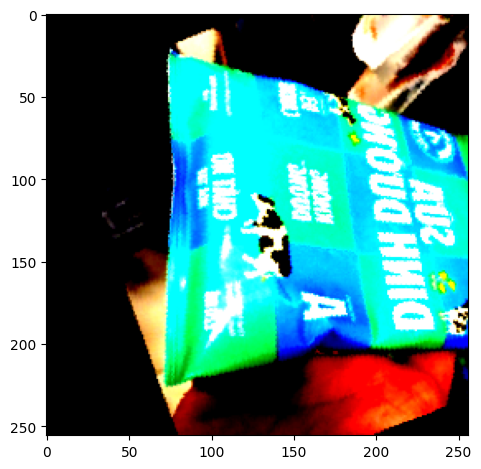

In [47]:
viz_utils.plot_image(train_dataset[1][0].detach().numpy().transpose(1, 2, 0))

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvMixer(dim=IMAGE_SIZE, depth=8, n_classes=len(train_dataset.classes)).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

766307


In [ ]:
raise

In [ ]:
# ---- Training Loop ----
def train(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Training epoch {epoch + 1}..."):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

        # Evaluation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        print(f"           Val Accuracy: {val_correct/val_total:.4f}")

# ---- Run Training ----
train(model, train_loader, val_loader, epochs=10)

Training epoch 1...:   0%|          | 0/85 [00:00<?, ?it/s]/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Training epoch 1...: 100%|██████████| 85/85 [16:36<00:00, 11.72s/it]

[Epoch 1] Train Loss: 358.9265, Accuracy: 0.0705



/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


           Val Accuracy: 0.1062


Training epoch 2...:   0%|          | 0/85 [00:00<?, ?it/s]/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Training epoch 2...: 100%|██████████| 85/85 [16:20<00:00, 11.54s/it]

[Epoch 2] Train Loss: 291.7868, Accuracy: 0.1596



/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


           Val Accuracy: 0.1316


Training epoch 3...:   0%|          | 0/85 [00:00<?, ?it/s]/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Training epoch 3...:   1%|          | 1/85 [00:14<20:52, 14.91s/it]